In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import ecco_v4_py as ecco

import cmocean.cm as cmo
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Import ECCO dataset

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

In [3]:
grid = ecco.get_llc_grid(main)

### Useful quantities

In [4]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Watts to Petawatts
pw = 1e-15

# m^3 to Sverdrup
Sv = 10**-6

In [5]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC)

### Volume flux

In [6]:
u_transport = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
v_transport = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

In [7]:
xvol  = u_transport.sum('k').mean('time').where(main.hFacW[0].values==1)*Sv
yvol  = v_transport.sum('k').mean('time').where(main.hFacS[0].values==1)*Sv

In [8]:
transport = xr.DataArray(np.sqrt(np.square(xvol[10].values)+np.square(yvol[10].values)),
                         coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

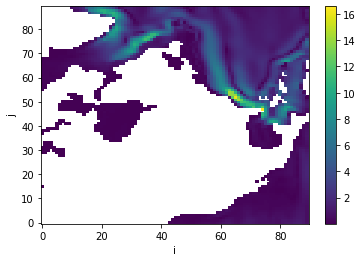

In [9]:
transport.plot()

#### Vector plot

In [12]:
x, y = np.meshgrid(np.arange(0,90,1),np.arange(0,90,1))

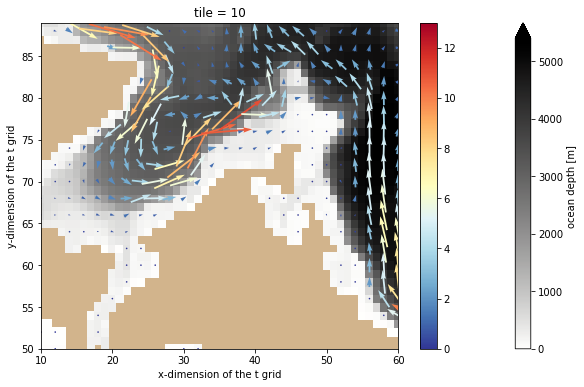

In [30]:
plt.figure(figsize=(10,6))

main.Depth[10].where(main.hFacC[0,10].values==1).plot(vmin=0, vmax=5400, cmap=cmo.gray_r)

plt.quiver(x[::2, ::2], y[::2, ::2], xvol[10][::2, ::2], yvol[10][::2, ::2], transport[::2, ::2],
           pivot='mid', scale=75, width=5e-3, cmap='RdYlBu_r')

plt.xlim([10,60])
plt.ylim([50,89])
plt.clim(0,13)

plt.colorbar()
plt.gca().set_facecolor('tan')
plt.show()

### Define the section lines 

In [46]:
# Southern flowing limb of the Labrador current
LCsouth_pt1,LCsouth_pt2 = ([-56., 49],[-43, 48])
maskC_LCs, maskW_LCs, maskS_LCs = ecco.get_section_line_masks(LCsouth_pt1,LCsouth_pt2,main)

# Eastward flowing limb of the Labrador current
LCeast_pt1,LCeast_pt2 = ([-43, 48],[-43, 55])
maskC_LCe, maskW_LCe, maskS_LCe = ecco.get_section_line_masks(LCeast_pt1,LCeast_pt2,main)

maskC_tot = (maskC_LCs + maskC_LCe).where(maskC_LCs + maskC_LCe==1,0)
maskW_tot = (maskW_LCs + maskW_LCe).where(np.abs(maskW_LCs) + np.abs(maskW_LCe)==1,0)
maskS_tot = (maskS_LCs + maskS_LCe).where(np.abs(maskS_LCs) + np.abs(maskS_LCe)==1,0)

(50.0, 89.0)

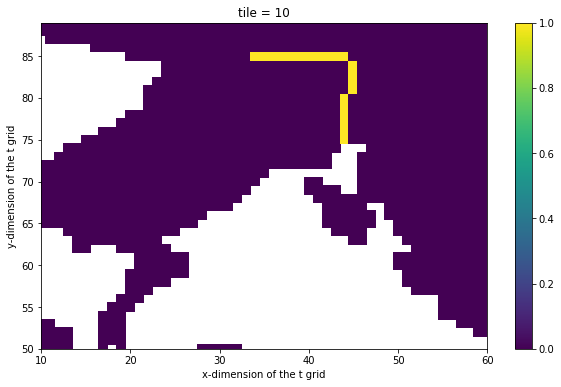

In [44]:
maskC_tot[10]E.plot(figsize=(10,6))
plt.xlim([10,60])
plt.ylim([50,89])
plt.show()

/usr/local/lib/python3.6/dist-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()
/usr/local/lib/python3.6/dist-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


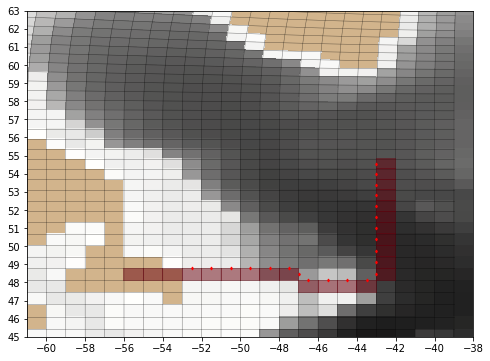

In [50]:
fig, ax = plt.subplots(figsize=(8,6))

main.Depth[10].where(main.hFacC[0,10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                      vmin=0, vmax=5400, cmap=cmo.gray_r,zorder=0)
# Plot grid line
plt.plot(main.XG[10], main.YG[10],'k-',alpha=0.5,lw=0.5,zorder=0)
plt.plot(main.XG[10].T, main.YG[10].T,'k-',alpha=0.5,lw=0.5,zorder=0)

# Plot section masks
maskC_tot[10].where(maskC_tot[10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                  vmin=0,vmax=1,cmap=plt.cm.Reds,alpha=0.5)

# Plot u and v points
j = maskW_tot[10].where((maskW_tot[10].values!=0)&(main.hFacW[0,10].values==1))\
                .to_dataframe(name='maskW').dropna().reset_index().j.values

i_g = maskW_tot[10].where((maskW_tot[10].values!=0)&(main.hFacW[0,10].values==1))\
                .to_dataframe(name='maskW').dropna().reset_index().i_g.values
plt.plot(main.XC.isel(tile=10).values[j,i_g],main.YG.isel(tile=10).values[j,i_g], c='r',marker='d',ls='none',ms=2)

j_g = maskS_tot[10].where((maskS_tot[10].values!=0)&(main.hFacS[0,10].values==1))\
                .to_dataframe(name='maskS').dropna().reset_index().j_g.values
i = maskS_tot[10].where((maskS_tot[10].values!=0)&(main.hFacS[0,10].values==1))\
                .to_dataframe(name='maskS').dropna().reset_index().i.values
plt.plot(main.XG.isel(tile=10).values[j_g,i],main.YC.isel(tile=10).values[j_g,i], c='r',marker='d',ls='none',ms=2)

ax.set_xlim([-61,-38])
ax.set_ylim([45,59])
ax.set_xticks(np.arange(-60,-36,2))
ax.set_yticks(np.arange(45,64,1))
ax.set_facecolor('tan')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

plt.show()

### Section transport

#### Southern flowing limb

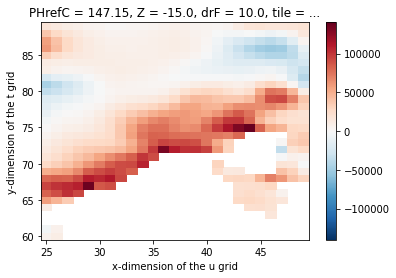

In [87]:
u_transport.mean('time').where(main.hFacW[0].values==1)[1,10,60:,25:50].plot()

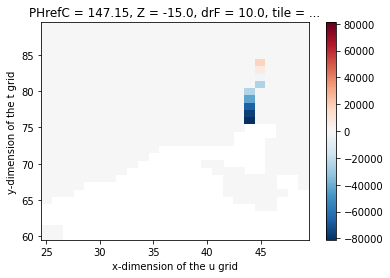

In [90]:
(u_transport * maskW_LCs).mean('time').where(main.hFacS[0].values==1)[1,10,60:,25:50].plot(cmap='RdBu_r')

In [84]:
# Volume transports
LCs_trsp_x = (u_transport * maskW_LCs).sum(dim=['i_g','j','tile'])
LCs_trsp_y = (v_transport * maskS_LCs).sum(dim=['i','j_g','tile'])
LCs_trsp = (LCs_trsp_x + LCs_trsp_y).sum('k').compute()*Sv

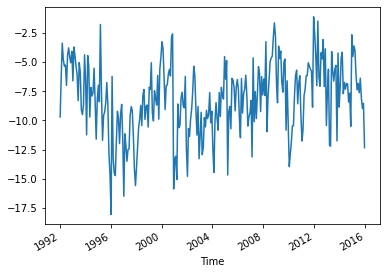

In [85]:
LCs_trsp.plot()

In [86]:
print('Volume flux (1992-2015):', 
      np.round(LCs_trsp.mean('time').values,2),'±',np.round(2*LCs_trsp.std('time').values,2),'Sv')

Volume flux (1992-2015): -8.1 ± 6.12 Sv


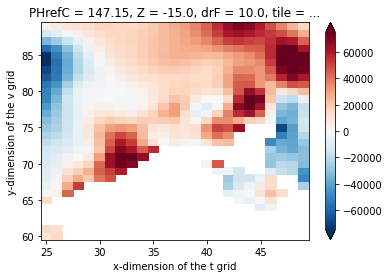

In [93]:
v_transport.mean('time').where(main.hFacS[0].values==1)[1,10,60:,25:50].plot(vmin=-7.5e4,vmax=7.5e4,cmap='RdBu_r')

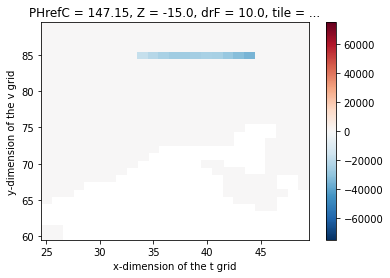

In [94]:
(v_transport * maskS_LCe).mean('time').where(main.hFacS[0].values==1)[1,10,60:,25:50].plot(vmin=-7.5e4,vmax=7.5e4,
                                                                                           cmap='RdBu_r')

In [95]:
# Volume transports
LCe_trsp_x = (u_transport * maskW_LCe).sum(dim=['i_g','j','tile'])
LCe_trsp_y = (v_transport * maskS_LCe).sum(dim=['i','j_g','tile'])
LCe_trsp = (LCe_trsp_x + LCe_trsp_y).sum('k').compute()*Sv*-1

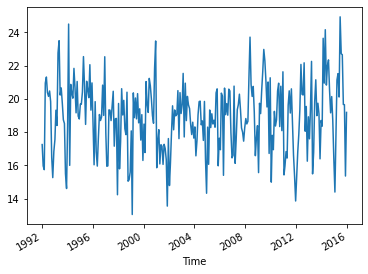

In [96]:
LCe_trsp.plot()

In [97]:
print('Volume flux (1992-2015):', 
      np.round(LCe_trsp.mean('time').values,2),'±',np.round(2*LCe_trsp.std('time').values,2),'Sv')

Volume flux (1992-2015): 18.89 ± 4.2 Sv


In [102]:
df = LCe_trsp.reset_coords(drop=True).to_dataframe(name='LC_east')

In [103]:
df['LC_south'] = LCs_trsp.reset_coords(drop=True).to_dataframe(name='LC_south')['LC_south']

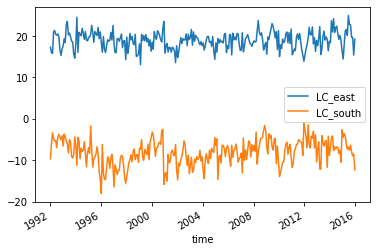

In [105]:
df.plot()

In [106]:
# Save with index column (time)
df.to_csv('/mnt/efs/data/ecco/eccov4r3_LC_trsp.csv', index=True)

### Heat flux

In [8]:
xheat  = main.ADVx_TH.sum('k').mean('time').where(main.hFacW[0].values==1)*rhoconst*c_p*pw
yheat  = main.ADVy_TH.sum('k').mean('time').where(main.hFacS[0].values==1)*rhoconst*c_p*pw

In [123]:
heat_trp = xr.DataArray(np.sqrt(np.square(xheat[10].values)+np.square(yheat[10].values)),
                        coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

#### Heat flux at the LG transect

In [69]:
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]

In [182]:
j = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().j.values

i_g = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().i_g.values
    
j_g = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().j_g.values
    
i = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().i.values

In [187]:
xc = main.XC.isel(tile=10).values[j,i_g]
yg = main.YG.isel(tile=10).values[j,i_g]
xg = main.XG.isel(tile=10).values[j_g,i]
yc = main.YC.isel(tile=10).values[j_g,i]

In [193]:
xheat_LG = ((main.ADVx_TH * maskW).sum(dim=['tile','k']).mean('time')*rhoconst*c_p*pw).values[j,i_g]*1e3
yheat_LG = ((main.ADVy_TH * maskS).sum(dim=['tile','k']).mean('time')*rhoconst*c_p*pw).values[j_g,i]*1e3

### Divide LG transect between north and south

In [195]:
#XW = grid.interp(main.XC, 'X', boundary='extend')
YW = grid.interp(main.YC, 'X', boundary='extend')

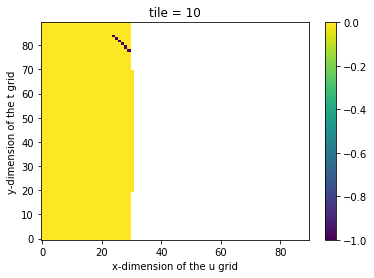

In [197]:
maskW.where(YW >= 57)[10].plot()

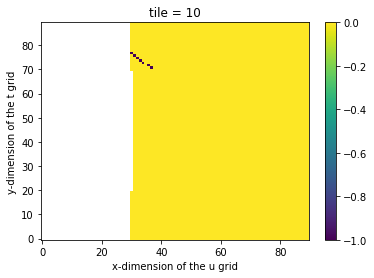

In [198]:
maskW.where(maskW.YW < 57)[10].plot()

In [201]:
YS = grid.interp(main.YC, 'Y', boundary='extend')

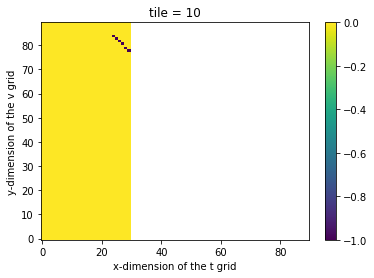

In [202]:
maskS.where(YS >= 57)[10].plot()

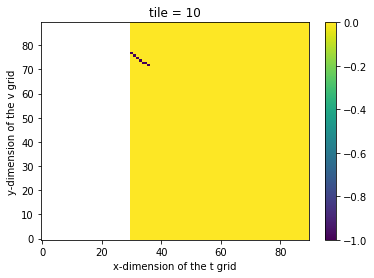

In [203]:
maskS.where(YS < 57)[10].plot()

In [210]:
sec_THtrsp_x_north = (ADVx_TH * maskW).where(YW >= 57).sum(dim=['i_g','j','tile'])
sec_THtrsp_x_south = (ADVx_TH * maskW).where(YW < 57).sum(dim=['i_g','j','tile'])

sec_THtrsp_y_north = (ADVy_TH * maskS).where(YS >= 57).sum(dim=['i','j_g','tile'])
sec_THtrsp_y_south = (ADVy_TH * maskS).where(YS < 57).sum(dim=['i','j_g','tile'])

In [212]:
sec_THtrsp_north = (sec_THtrsp_x_north + sec_THtrsp_y_north).sum('k').compute()*rhoconst*c_p*pw*1000
sec_THtrsp_south = (sec_THtrsp_x_south + sec_THtrsp_y_south).sum('k').compute()*rhoconst*c_p*pw*1000

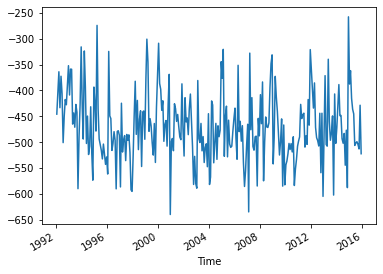

In [214]:
sec_THtrsp_south.plot()

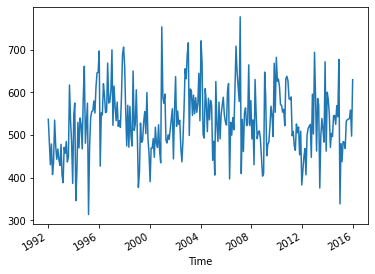

In [213]:
sec_THtrsp_north.plot()

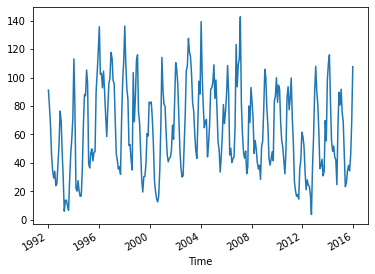

In [215]:
heat_trsp.plot()

In [216]:
from datetime import date
import matplotlib.dates as dates

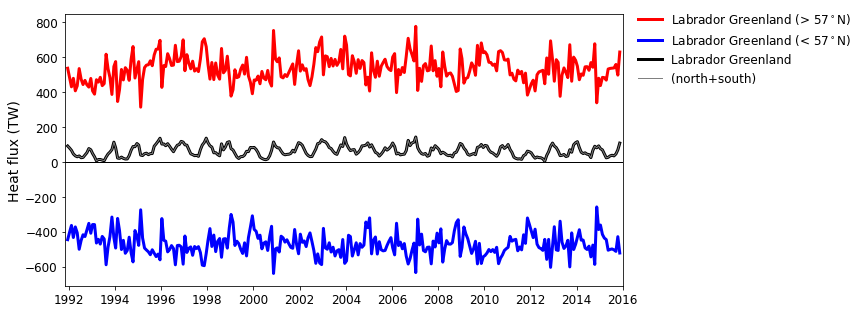

In [228]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(sec_THtrsp_north.time, sec_THtrsp_north,color='red', lw=3, label='Labrador Greenland (> 57$^\circ}$N)')
ax.plot(sec_THtrsp_south.time, sec_THtrsp_south,color='blue', lw=3, label='Labrador Greenland (< 57$^\circ}$N)')
ax.plot(heat_trsp.time, heat_trsp,color='k', lw=3, label='Labrador Greenland')
ax.plot(heat_trsp.time, sec_THtrsp_north+sec_THtrsp_south,color='grey', lw=1, label='(north+south)')

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Heat flux (TW)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12,bbox_to_anchor=(1.43, 1.05))

plt.show()

In [229]:
sec_THtrsp_north_anom = sec_THtrsp_north.groupby('time.month') - sec_THtrsp_north.groupby('time.month').mean('time')
sec_THtrsp_south_anom = sec_THtrsp_south.groupby('time.month') - sec_THtrsp_south.groupby('time.month').mean('time')
heat_trsp_anom = heat_trsp.groupby('time.month') - heat_trsp.groupby('time.month').mean('time')

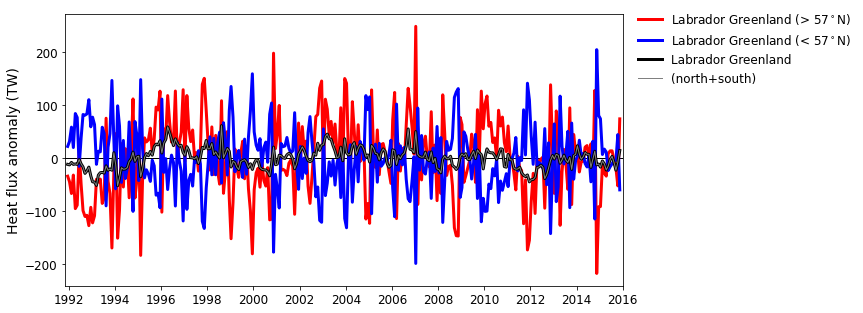

In [231]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(sec_THtrsp_north.time, sec_THtrsp_north_anom, color='red', lw=3, label='Labrador Greenland (> 57$^\circ}$N)')
ax.plot(sec_THtrsp_south.time, sec_THtrsp_south_anom, color='blue', lw=3, label='Labrador Greenland (< 57$^\circ}$N)')
ax.plot(heat_trsp.time, heat_trsp_anom,color='k', lw=3, label='Labrador Greenland')
ax.plot(heat_trsp.time, sec_THtrsp_north_anom+sec_THtrsp_south_anom,color='grey', lw=1, label='(north+south)')

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Heat flux anomaly (TW)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12,bbox_to_anchor=(1.43, 1.05))

plt.show()

In [250]:
df = pd.DataFrame({'time':heat_trsp.time,'total':heat_trsp_anom*1e12,
                   'north':sec_THtrsp_north_anom*1e12,'south':sec_THtrsp_south_anom*1e12})
df.set_index('time',inplace=True)

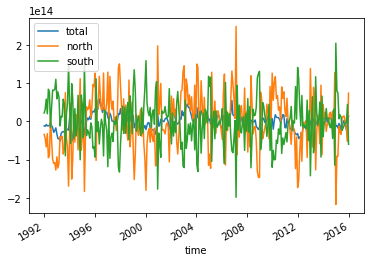

In [251]:
df.plot()

In [252]:
df['dt'] = main.reset_coords().dt.to_dataframe().dt

In [253]:
# 6-month
df_sub = df.loc[(df.index > '1992-06-30')&(df.index <= '2016-01-01')]
df_6mo = df_sub.multiply(df_sub["dt"], axis="index").resample('6M',kind='period').sum().drop(columns=['dt'])

# Annual
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

# 2-year
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_2yr = df_sub.multiply(df_sub["dt"], axis="index").resample('2A',kind='period').sum().drop(columns=['dt'])

# Pentad
df_sub = df.loc[(df.index > '1994-12-31')&(df.index < '2015-01-01')]
df_5yr = df_sub.multiply(df_sub["dt"], axis="index").resample('5A',kind='period').mean().drop(columns=['dt'])

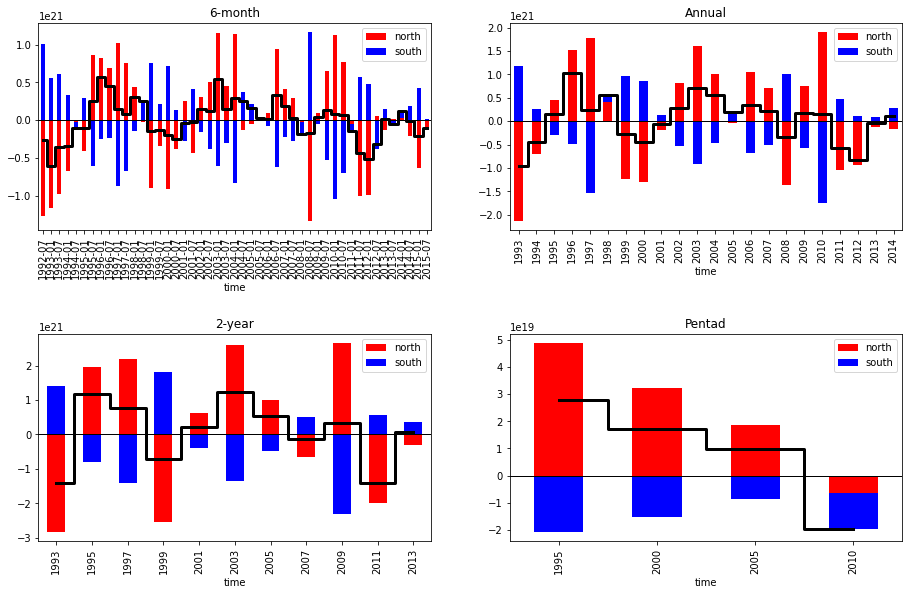

In [284]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.5, wspace=0.2)

df_6mo.drop(columns=['total']).plot.bar(stacked=True,color=['r','b'],ax=axs[0,0])
axs[0,0].step(df_6mo.index.strftime('%Y-%m'), df_6mo.total, where='mid', c='k', lw=3, linestyle='-')
axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].set_title('6-month')

df_1yr.drop(columns=['total']).plot.bar(stacked=True,color=['r','b'],ax=axs[0,1])
axs[0,1].step(df_1yr.index.strftime('%y'), df_1yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].set_title('Annual')

df_2yr.drop(columns=['total']).plot.bar(stacked=True,color=['r','b'],ax=axs[1,0])
axs[1,0].step(df_2yr.index.strftime('%Y'), df_2yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].set_title('2-year')

df_5yr.drop(columns=['total']).plot.bar(stacked=True,color=['r','b'],ax=axs[1,1])
axs[1,1].step(df_5yr.index.strftime('%Y'), df_5yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].set_title('Pentad')
plt.show()

### Integrate anomalies

In [264]:
df['dt'] = main.reset_coords().dt.to_dataframe().dt

In [274]:
df_int = df.multiply(df['dt'], axis='index').cumsum().drop(columns=['dt'])

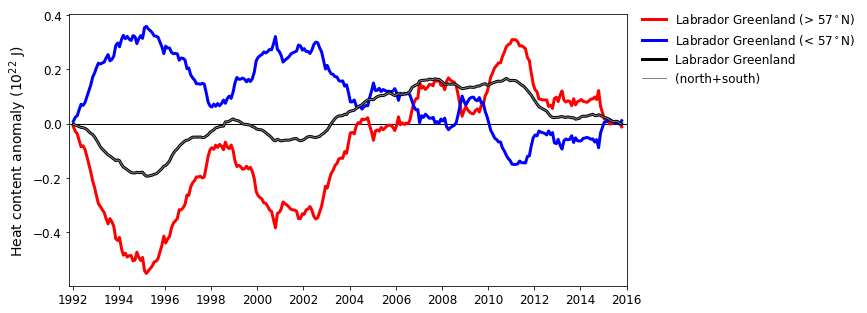

In [281]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(df_int.index, df_int.north*1e-22, color='red', lw=3, label='Labrador Greenland (> 57$^\circ}$N)')
ax.plot(df_int.index, df_int.south*1e-22, color='blue', lw=3, label='Labrador Greenland (< 57$^\circ}$N)')
ax.plot(df_int.index, df_int.total*1e-22, color='k', lw=3, label='Labrador Greenland')
ax.plot(df_int.index, (df_int.north+df_int.south)*1e-22, color='grey', lw=1, label='(north+south)')

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Heat content anomaly (10$^{22}$ J)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12,bbox_to_anchor=(1.43, 1.05))

plt.show()